# Using Trained Model
### Nicolas Guerra
### May 14, 2024
This notebook plots the conductivity produced by the trained model and compares it with the true solution.

In [3]:
import copy
import json
import os
import random
import sys
from timeit import default_timer as timer

import numpy as np
import csv
import pandas as pd
import torch
import torch.optim as optim
from GPUtil.GPUtil import getGPUs
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm

from Baselines import InversionNetHelm, InversionNetRad, InversionNetEIT
from NIOModules import NIOHelmPermInv, NIOHeartPerm, NIORadPerm, NIOWavePerm
from NIOModules import SNOHelmConv, SNOWaveConv2, SNOConvEIT, SNOConvRad
from debug_tools import CudaMemoryDebugger

from Problems.PoissonSin_FullDtN import MyDataset

import numpy as np
import torch
import torch.nn as nn

from Baselines import EncoderInversionNet, EncoderHelm, EncoderRad, EncoderHelm2, EncoderInversionNet2, EncoderRad2
from DeepONetModules import FeedForwardNN, FourierFeatures, DeepOnetNoBiasOrg
from FNOModules import FNO2d, FNO1d, FNO_WOR, FNO1d_WOR

import h5py
import torch
import numpy as np
from torch.utils.data import Dataset

from Problems.PoissonSin_FullDtN import MyDataset

import pickle
import dill

In [4]:
# Load Trained Model (Model trained OnlyNBC and dbc generated with w=2pi)
model = torch.load("GRF_GaussianMean0/model.pkl")
#model.eval()

/tmp/ipykernel_2431291/2200143994.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("GRF_GaussianMean0/model.pkl")


In [5]:
# Read in training and testing data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '../data/Calderon_n70_L20_GaussianGRF_numterms20_a0.5_e2.h5'

torch.manual_seed(1) # Reproducibility (noise is random)
train_dataset = MyDataset(norm='norm', inputs_bool=2, device=device, which="training", mod='nio_new',data_path=data_path)
test_dataset = MyDataset(norm='norm', inputs_bool=2, device=device, which="validation", mod='nio_new', noise=.1, data_path=data_path)

Training with  4096  samples
Using  4096  Training Samples
Training with  4096  samples


To get the NBC, DBC, and conductivity data from sample 0:
* samples_concat = test_dataset[0][0] (DBC and NBC data are concatenated.)
* Conductivity = test_dataset[0][1]

To get the grid:
* grid = train_dataset.get_grid().squeeze(0)

In [23]:
grid = test_dataset.get_grid().squeeze(0)
sample_i = 1
sample_concat = test_dataset[sample_i][0]
sample_concat=torch.reshape(sample_concat, (1, 20, 1, 8, 69)) # reshaped so it is like "1 batch"

true_conductivity = test_dataset[sample_i][1]

In [24]:
grid = grid.to(device, non_blocking=True)
sample_concat = sample_concat.to(device, non_blocking=True)
predicted_conductivity = model(sample_concat,grid)

## Plotting

In [25]:
import matplotlib.pyplot as plt

(-0.5, 69.5, 69.5, -0.5)

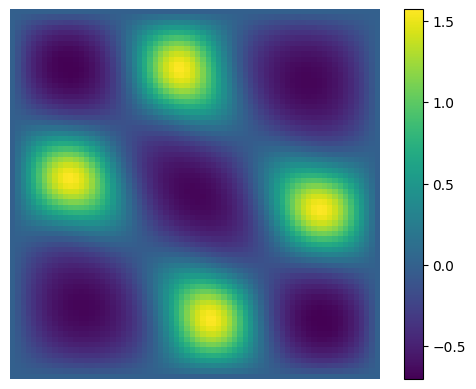

In [26]:
plt.imshow(true_conductivity)
plt.colorbar()
plt.axis('off')

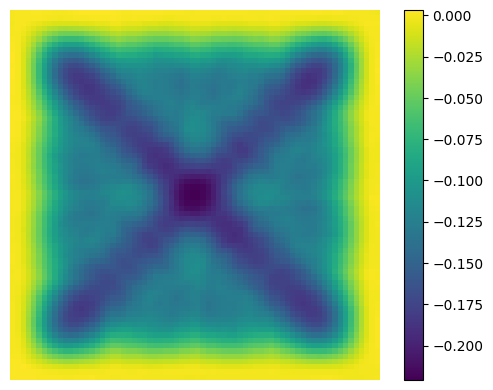

In [27]:
predicted_conductivity = torch.reshape(predicted_conductivity.cpu(),(70,70)).detach().numpy()
plt.imshow(predicted_conductivity)
plt.axis('off')
plt.colorbar()

(-0.5, 69.5, 69.5, -0.5)

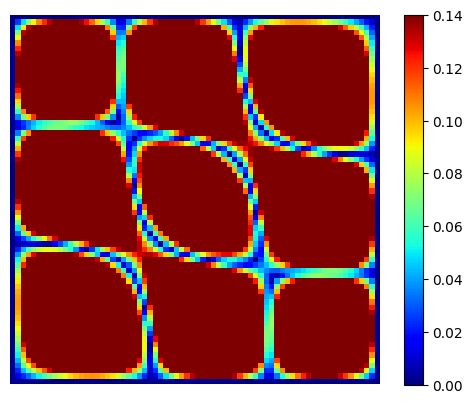

In [28]:
plt.imshow(np.abs(true_conductivity-predicted_conductivity), vmin=0, vmax=.14, cmap='jet')
plt.colorbar()
plt.axis('off')